In [1]:
import random
import plotly.express as px
from infomap import Infomap
import plotly.graph_objects as go
from collections import Counter
from collections import defaultdict
import string
import networkx as nx
import numpy as np
from tqdm import tqdm
from itertools import combinations
import os
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from ast import literal_eval
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
def setup_mpl():
    mpl.rcParams['font.family'] = 'Times New Roman'
    mpl.rcParams['lines.linewidth'] = 2
    return
setup_mpl()

In [3]:
#Getting data
df_marvel = pd.read_csv("files/marvel.csv", index_col=0, encoding='utf8')
df_marvel = df_marvel[df_marvel["WikiLink"].notna()]
df_dc = pd.read_csv("files/dc.csv", index_col=0, encoding='utf8')
df_dc = df_dc[df_dc["WikiLink"].notna()]
df_marvel['universe'] = 'Marvel'
df_dc['universe'] = 'DC'
df = pd.concat([df_marvel, df_dc], ignore_index=True, axis=0)

edgelist = pd.read_csv("corrected_edgelist.csv")
temp = pd.merge(edgelist, df, left_on='source', right_on='WikiLink')
temp = temp.rename(columns={"universe":"source universe"})
temp = temp.drop(columns=['CharacterName', 'WikiLink'])
temp = pd.merge(temp, df, left_on='target', right_on='WikiLink')
temp = temp.rename(columns={"universe":"target universe"})
temp = temp.drop(columns=['CharacterName', 'WikiLink'])
expanded_edgelist = temp.copy()

In [4]:
def ensemble_infomap(graph, N, k=None, threshold = 0.9, verbose=False, seed=0):
    '''
    1) run several trials of Infomap on the same network,
    2) built a new network where a pair of the original nodes is linked if their total co-membership across all the Louvain trials is above a given threshold (e.g., 90%),
    3) identify the disjoints sets which represent the resulting communities.'''
    
    #preperation
    graph = nx.convert_node_labels_to_integers(graph, label_attribute="org_name")
    names = nx.get_node_attributes(graph, "org_name")
    
    #step 1
    tot_communities = []
    for iter_ in tqdm(range(N), disable=not verbose):
        
        im = Infomap(directed=True, silent=not verbose, seed=seed+iter_) #Using new seed
        for edge in graph.edges():
            im.addLink(*edge)
        im.run()
        communities = {}
        for node in im.tree:
            if node.is_leaf:
                communities[names[node.node_id]] = node.module_id
        tot_communities.append(communities)
    
    #preperation
    graph = nx.relabel_nodes(graph, names)
    
    #step 2
    G_new = nx.Graph()
    G_new.add_nodes_from(list(graph.nodes))
    node_pairs = combinations(list(graph.nodes), 2)
    for (u,v) in tqdm(node_pairs, disable=not verbose):
        co_occurence = 0
        for partitions in tot_communities:
            if partitions[u] == partitions[v]: 
                co_occurence += 1
        if co_occurence/N > threshold:
            G_new.add_edge(u, v)
        
        
    #step 3
    if k == None:
        k = nx.number_connected_components(G_new)
    k_greatest_components = {i: list(community) for i, community in enumerate(sorted(nx.connected_components(G_new), key=len, reverse=True)[:k])}
    
    
    return k_greatest_components


In [5]:
edgelist_temp = expanded_edgelist[expanded_edgelist.timestamp==2021]
G_2021 = nx.from_pandas_edgelist(edgelist_temp, create_using = nx.DiGraph)

Let us try to examine if the text similarity is higher within clusters than between:

In [46]:
communities = ensemble_infomap(graph=G_2021, N=100, k=10, threshold=0.9, verbose=False)

In [13]:
meta_df = pd.read_csv('metadataproject.csv')
onehot = meta_df[['asian', 'latino', 'black']].values
equal_max = np.partition(onehot, -2)[:, -2:].T
default = -1 #-1 indicate no gender assignment
argmax = np.where(equal_max[0] != equal_max[1], np.argmax(onehot, -1), default)
race_map = {2:'black', 1:'latino', 0:'asian', -1:'unspecified'}
meta_df['race'] = argmax
meta_df["race"].replace(race_map, inplace=True)
onehot = meta_df[['woman', 'man']].values
equal_max = np.partition(onehot, -2)[:, -2:].T
default = -1 #-1 indicate no gender assignment
argmax = np.where(equal_max[0] != equal_max[1], np.argmax(onehot, -1), default)

sex_map = {0:'woman', 1:'man', -1:'unspecified'}
meta_df['sex'] = argmax
meta_df["sex"].replace(sex_map, inplace=True)
meta_df = meta_df[['CharacterName', 'WikiLink', 'universe', 'race', 'sex']]

corpus = pd.read_csv('project_folder/text_corpus.csv')
corpus_2021 = corpus[corpus.TimeStamp==2021]
corpus_2021['tokens'] = corpus_2021['tokens'].apply(literal_eval)

mask = [not elem for elem in (corpus_2021.RawText.str.lower().str.contains('redirect')) & (corpus_2021['#tokens']<=56) |(corpus_2021['#tokens']==1)]
corpusv2 = corpus_2021[mask]

extended_corpus = pd.merge(corpusv2, meta_df, left_on='CharacterName', right_on='CharacterName')

/var/folders/w8/wb7dt4yd6ys326nsmh5q64200000gn/T/ipykernel_3530/1861158984.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_2021['tokens'] = corpus_2021['tokens'].apply(literal_eval)


In [14]:
extended_corpus

,CharacterName,TimeStamp,RawText,tokens,#tokens,WikiLink,universe,race,sex
0,Abomination,2021,{{Short description|Marvel Comics fictional ch...,"[short, comic, fiction, charact, infobox, comi...",3108,Abomination (character),Marvel,unspecified,man
1,Absorbing Man,2021,{{Short description|Marvel Comics fictional ch...,"[short, comic, fiction, charact, infobox, comi...",2498,Absorbing Man,Marvel,unspecified,man
2,Agent,2021,{{Short description|Fictional character in Mar...,"[short, charact, marvel, comic, wikipedia, wik...",467,Agent (comics),Marvel,unspecified,man
3,Agent X,2021,{{short description|Fictional comic book chara...,"[short, comic, book, charact, use, agent, x, x...",1405,Agent X (Marvel Comics),Marvel,unspecified,man
4,Airstrike,2021,{{Infobox comics character <!--Wikipedia:Wiki...,"[infobox, comic, charact, wikipedia, wikiproje...",728,Dmitri Bukharin,Marvel,unspecified,unspecified
...,...,...,...,...,...,...,...,...,...
1808,Xiuhtecutli,2021,{{Infobox comics organization\n<!--Wikipedia:W...,"[infobox, comic, organ, wikipedia, wikiproject...",659,Cadre (comics)#Cadre of the Immortal,DC,black,unspecified
1809,Xolotl,2021,{{in-universe|date=November 2010}}\n{{Infobox ...,"[infobox, fiction, locat, name, hell, imag, ca...",4716,Hell (DC Comics)#Fiends,DC,latino,unspecified
1810,Xombi,2021,{{short description|Fictional comics character...,"[short, comic, charact, disambigu, xombi, info...",724,Xombi,DC,asian,man
1811,4-D,2021,{{redirect|Pulse 8|the Jme song|Integrity (alb...,"[jme, album, infobox, comic, organ, wikipedia,...",793,International Ultramarine Corps#Founding membe...,DC,unspecified,unspecified


In [47]:
#flip dictionary
flip_dict = {}
for (c, n) in communities.items():
    for node in n:
        flip_dict[node] = c

In [48]:
communities_pd = []
for (idx, row) in extended_corpus.iterrows():
    if row.WikiLink in list(flip_dict.keys()):
        communities_pd.append(flip_dict[row.WikiLink])
    else:
        communities_pd.append(-1)

In [49]:
extended_corpus['Communities'] = communities_pd

In [50]:
extended_corpus.head()

,CharacterName,TimeStamp,RawText,tokens,#tokens,WikiLink,universe,race,sex,Communities
0,Abomination,2021,{{Short description|Marvel Comics fictional ch...,"[short, comic, fiction, charact, infobox, comi...",3108,Abomination (character),Marvel,unspecified,man,-1
1,Absorbing Man,2021,{{Short description|Marvel Comics fictional ch...,"[short, comic, fiction, charact, infobox, comi...",2498,Absorbing Man,Marvel,unspecified,man,-1
2,Agent,2021,{{Short description|Fictional character in Mar...,"[short, charact, marvel, comic, wikipedia, wik...",467,Agent (comics),Marvel,unspecified,man,-1
3,Agent X,2021,{{short description|Fictional comic book chara...,"[short, comic, book, charact, use, agent, x, x...",1405,Agent X (Marvel Comics),Marvel,unspecified,man,-1
4,Airstrike,2021,{{Infobox comics character <!--Wikipedia:Wiki...,"[infobox, comic, charact, wikipedia, wikiproje...",728,Dmitri Bukharin,Marvel,unspecified,unspecified,2


In [51]:
reordered_df = extended_corpus.sort_values('Communities')

In [52]:
reordered_df = reordered_df[reordered_df.Communities != -1]

In [71]:
def identity_tokenizer(text):
    return text


vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer,
                         lowercase=False,
                         max_df=0.7,
                         min_df = 0.1,
                        )

X = vectorizer.fit_transform(reordered_df['tokens'])

In [72]:
#Computing pairwise cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
A = cosine_similarity(X)
#Setting diagonal to zero because we don't care about similarity between the same document.
np.fill_diagonal(A, 0.0)

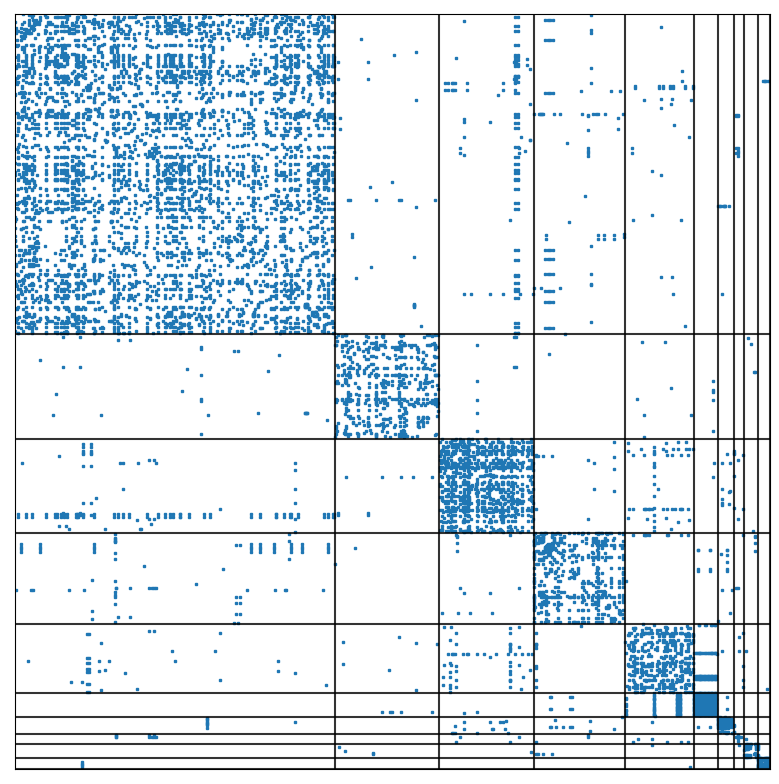

In [73]:
#Initially we will use the ground truth universe labels for the reordering

labels = list(reordered_df.Communities.values)
#new_order = labels.argsort()

#_, group_len = np.unique(labels, return_counts=True)


#D = A[:, new_order][new_order]
D = A

fig, (ax1) = plt.subplots(figsize=(10,10), dpi=100)
#ax1.spy(D, precision=0.5, markersize=0.5)
ax1.spy(D, precision=0.5, markersize=2)
ax1.set_xticks([])
ax1.set_yticks([])
#ax1.set_title("Pairwise Cosine Similarity \n reordered by ground truth")

y = labels
N = A.shape[0]
counts=np.unique(y,return_counts=True)[1]
counts_j=np.unique(y,return_counts=True)[1]
cum_i=np.cumsum(counts)
cum_j=np.cumsum(counts_j)

for i in range(cum_i.shape[0]):
    x1=np.array([cum_i[i],cum_i[i]])
    y1=np.array([[0,N]])
    line = plt.Line2D(y1, x1, lw=1.5, color='k', alpha=0.8)
    ax1.add_line(line)

for i in range(cum_i.shape[0]):
    x1=np.array([cum_j[i],cum_j[i]])
    y1=np.array([[0,N]])
    line = plt.Line2D(x1, y1, lw=1.5, color='k', alpha=0.8)
    ax1.add_line(line)

plt.show()


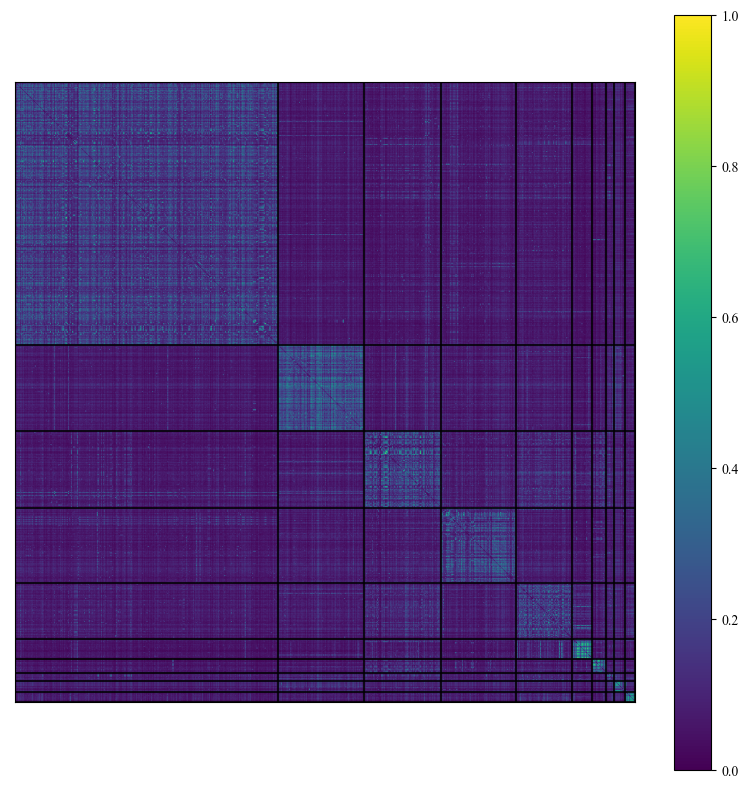

In [75]:
labels = list(reordered_df.Communities.values)
D = A

fig, (ax1) = plt.subplots(figsize=(10,10), dpi=100)
im = ax1.imshow(D)
fig.colorbar(im)
ax1.set_xticks([])
ax1.set_yticks([])

y = labels
N = A.shape[0]
counts=np.unique(y,return_counts=True)[1]
counts_j=np.unique(y,return_counts=True)[1]
cum_i=np.cumsum(counts)
cum_j=np.cumsum(counts_j)

for i in range(cum_i.shape[0]):
    x1=np.array([cum_i[i],cum_i[i]])
    y1=np.array([[0,N]])
    line = plt.Line2D(y1, x1, lw=1.5, color='k', alpha=0.8)
    ax1.add_line(line)

for i in range(cum_i.shape[0]):
    x1=np.array([cum_j[i],cum_j[i]])
    y1=np.array([[0,N]])
    line = plt.Line2D(x1, y1, lw=1.5, color='k', alpha=0.8)
    ax1.add_line(line)

plt.savefig('community_homophily.png', dpi=100)
plt.show()

In [99]:
expanded_edgelist

,source,target,timestamp,source universe,target universe
0,Abomination (character),Silver Surfer,2014,Marvel,Marvel
1,Abomination (character),Silver Surfer,2019,Marvel,Marvel
2,Abomination (character),Silver Surfer,2012,Marvel,Marvel
3,Abomination (character),Silver Surfer,2010,Marvel,Marvel
4,Abomination (character),Silver Surfer,2011,Marvel,Marvel
...,...,...,...,...,...
361208,Xombi,Cowgirl (comics),2013,DC,Marvel
361209,Xombi,Cowgirl (comics),2012,DC,Marvel
361210,Xombi,Cowgirl (comics),2011,DC,Marvel
361211,Xombi,Cowgirl (comics),2020,DC,Marvel


In [106]:
node_order = [node for node in G_2021.nodes()]
A = nx.adjacency_matrix(G_2021, nodelist=node_order).todense()

In [107]:
communities = ensemble_infomap(graph=G_2021, N=100, threshold=0.9, verbose=False)

In [108]:
#flip dictionary
flip_dict = {}
for (c, n) in communities.items():
    for node in n:
        flip_dict[node] = c

In [109]:
communities_order = []
for node in node_order:
    communities_order.append(flip_dict[node])

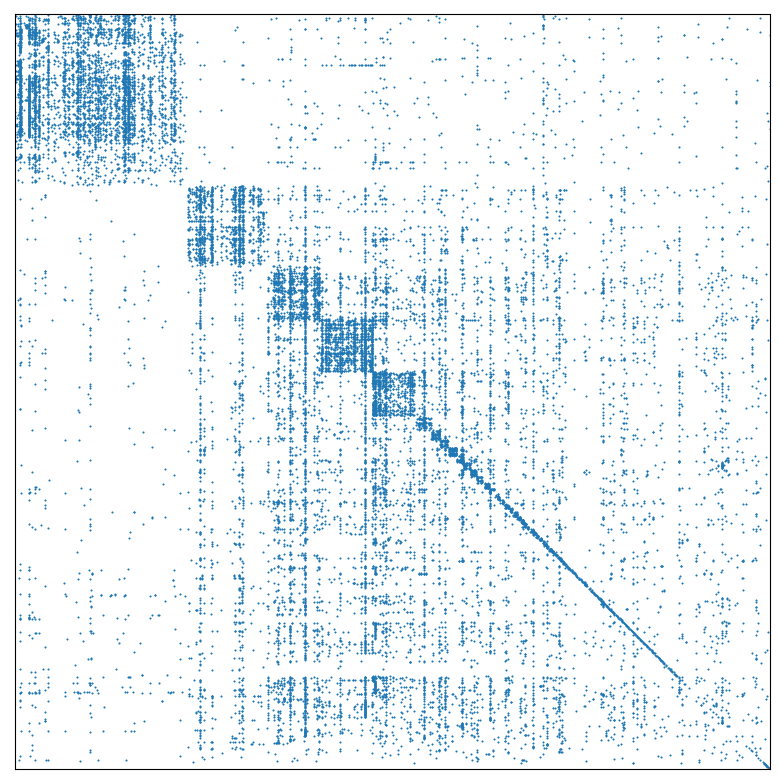

In [122]:
#Initially we will use the ground truth universe labels for the reordering

labels = np.array(communities_order)
new_order = labels.argsort()

D = A[:, new_order][new_order]

fig, (ax1) = plt.subplots(figsize=(10,10), dpi=100)
ax1.spy(D, markersize=0.5)
ax1.set_xticks([])
ax1.set_yticks([])
#ax1.set_title("Pairwise Cosine Similarity \n reordered by ground truth")

#y = labels
#N = A.shape[0]
#counts=np.unique(y,return_counts=True)[1]
#counts_j=np.unique(y,return_counts=True)[1]
#cum_i=np.cumsum(counts)
#cum_j=np.cumsum(counts_j)

#for i in range(10):#(cum_i.shape[0]):
#    x1=np.array([cum_i[i],cum_i[i]])
#    y1=np.array([[0,N]])
#    line = plt.Line2D(y1, x1, lw=1.5, linestyle='dashed', color='k', alpha=0.8)
#    ax1.add_line(line)

#for i in range(10):#(cum_i.shape[0]):
#    x1=np.array([cum_j[i],cum_j[i]])
#    y1=np.array([[0,N]])
#    line = plt.Line2D(x1, y1, lw=1.5, linestyle='dashed', color='k', alpha=0.8)
#    ax1.add_line(line)

plt.savefig('reordered_adjacency_matrix_v2.png', dpi=100)
plt.show()